# Experiment 5: K-Means Clustering after Autoencoder Dimensionality Reduction

## Imports and Configuration

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.autoencoder import Autoencoder
from src.models.kmeans import KMeans, KMeansInit
from src.utils.metrics import *
from src.utils.utils import *

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Data Loading and Preprocessing

In [8]:
X_scaled, y_true = load_scale_data(data_path='./data/breast_cancer.csv')

print(f"Dataset shape: {X_scaled.shape}")
print(f"Labels shape: {y_true.shape}")

Dataset shape: (569, 30)
Labels shape: (569,)


## Training and Evaluation Loop

In [9]:
bottleneck_dims = [2, 5, 10, 15, 20] # 
ae_kms_results = []
all_loss_histories = {}

for b_dim in bottleneck_dims:
    print(f"Training Autoencoder with Bottleneck: {b_dim}...")
    
    # Initialize Autoencoder [cite: 18, 20, 24]
    ae = Autoencoder(
        input_dim=X_scaled.shape[1],
        encoding_dims=[64, 32], # Two hidden + bottleneck = 3 layers 
        bottleneck_dim=b_dim,
        activation='relu',
        learning_rate=0.001,
        l2_lambda=0.01, # Regularization [cite: 24]
        epochs=150,
        batch_size=32 # Mini-batch GD [cite: 22]
    )
    
    # Train and record loss [cite: 92]
    ae.fit(X_scaled, verbose=False)
    all_loss_histories[b_dim] = ae.train_loss_history
    
    # 1. Dimensionality Reduction Quality [cite: 89, 90]
    recon_error = ae.reconstruction_error(X_scaled)
    X_latent = ae.encode(X_scaled)
    
    # 2. Clustering in Latent Space [cite: 59]
    km = KMeans(K=2, init=KMeansInit.KMEANS_PLUS_PLUS, random_state=42)
    km.fit(X_latent)
    y_pred = km.clusters
    
    # 3. Validation Metrics [cite: 75, 76, 83]
    ae_kms_results.append({
        'Bottleneck': b_dim,
        'Reconstruction MSE': recon_error,
        'ARI': compute_ari(y_true, y_pred),
        'NMI': compute_nmi(y_true, y_pred),
        'Silhouette': compute_silhouette_score(X_latent, y_pred),
        'Purity': purity_score(y_true, y_pred),
        'DB_Index': compute_davies_bouldin(X_latent, y_pred)
    })

results_df = pd.DataFrame(ae_kms_results)
results_df

Training Autoencoder with Bottleneck: 2...
Training Autoencoder with Bottleneck: 5...
Training Autoencoder with Bottleneck: 10...
Training Autoencoder with Bottleneck: 15...
Training Autoencoder with Bottleneck: 20...


,Bottleneck,Reconstruction MSE,ARI,NMI,Silhouette,Purity,DB_Index
0,2,0.999891,0.002817,0.000996,0.991565,0.627417,0.097722
1,5,0.828903,0.104615,0.080776,0.824460,0.687170,0.444631
2,10,0.796806,0.208906,0.309246,0.590737,0.731107,0.617133
3,15,0.472280,0.331896,0.330539,0.625165,0.796134,0.702903
4,20,0.376416,0.200915,0.154022,0.533427,0.736380,0.941282


## Training Loss Curves

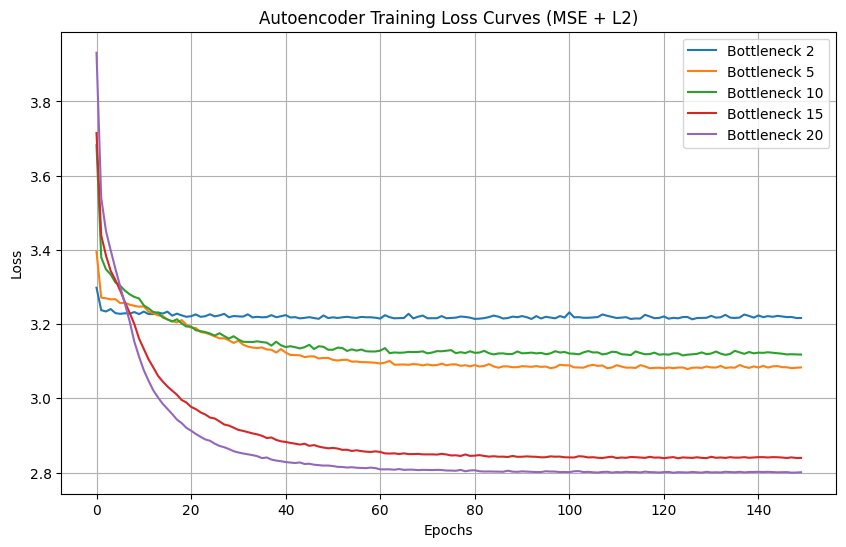

In [10]:
plt.figure(figsize=(10, 6))
for b_dim, history in all_loss_histories.items():
    plt.plot(history, label=f'Bottleneck {b_dim}')
plt.title("Autoencoder Training Loss Curves (MSE + L2)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## Reconstruction Loss vs. Clustering Performance Analysis

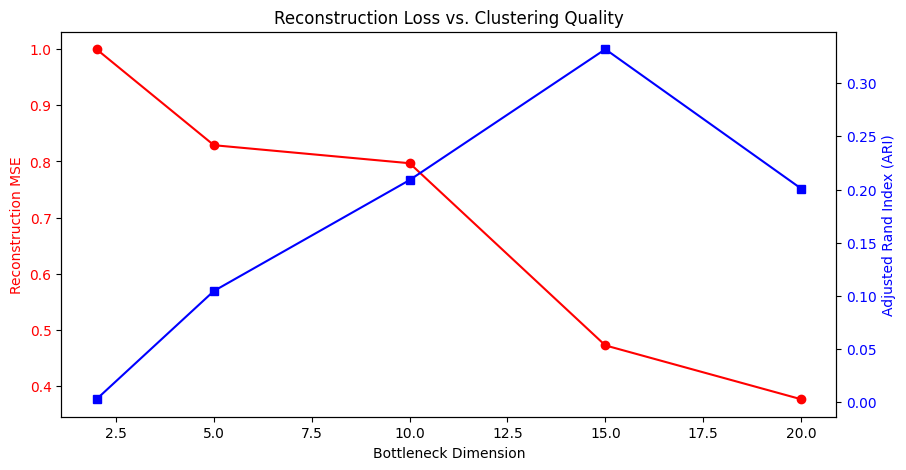

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Bottleneck Dimension')
ax1.set_ylabel('Reconstruction MSE', color='red')
ax1.plot(results_df['Bottleneck'], results_df['Reconstruction MSE'], color='red', marker='o', label='MSE')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Adjusted Rand Index (ARI)', color='blue')
ax2.plot(results_df['Bottleneck'], results_df['ARI'], color='blue', marker='s', label='ARI')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title("Reconstruction Loss vs. Clustering Quality")
plt.show()

## 2D Projection and Clusters

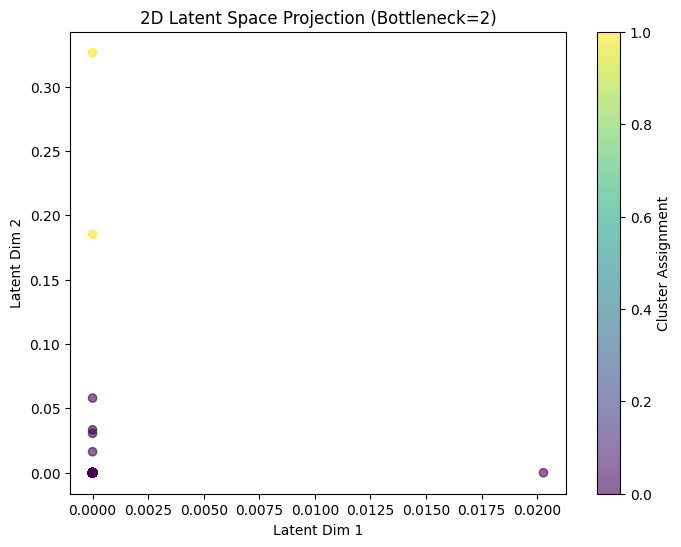

In [12]:
ae_2d = Autoencoder(X_scaled.shape[1], [64, 32], 2).fit(X_scaled, verbose=False)
X_2d = ae_2d.encode(X_scaled)
km_2d = KMeans(K=2).fit(X_2d)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=km_2d.clusters, cmap='viridis', alpha=0.6)
plt.title("2D Latent Space Projection (Bottleneck=2)")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.colorbar(label='Cluster Assignment')
plt.show()